In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing Libraries

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [67]:
#————————————————————————————————————————————————————
X=[]
Z=[]
IMG_SIZE=64
FLOWER_DAISY_DIR='../input/kk3flowers/flowers_TRAIN/flowers_TRAIN/daisy'
FLOWER_SUNFLOWER_DIR='../input/kk3flowers/flowers_TRAIN/flowers_TRAIN/sunflower'
FLOWER_TULIP_DIR='../input/kk3flowers/flowers_TRAIN/flowers_TRAIN/tulip'
FLOWER_DANDI_DIR='../input/kk3flowers/flowers_TRAIN/flowers_TRAIN/dandelion'
FLOWER_ROSE_DIR='../input/kk3flowers/flowers_TRAIN/flowers_TRAIN/rose'

def assign_label(img,flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        _, ftype = os.path.splitext(path)
        if ftype == ".jpg":
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X.append(np.array(img))
            Z.append(str(label))


            
            
            
#————————————————————————————————————————————————————
X1=[]
Z1=[]

FLOWER_DAISY_DIR1='../input/kk3flowers/flowers_TEST/flowers_TEST/daisy'
FLOWER_SUNFLOWER_DIR1='../input/kk3flowers/flowers_TEST/flowers_TEST/sunflower'
FLOWER_TULIP_DIR1='../input/kk3flowers/flowers_TEST/flowers_TEST/tulip'
FLOWER_DANDI_DIR1='../input/kk3flowers/flowers_TEST/flowers_TEST/dandelion'
FLOWER_ROSE_DIR1='../input/kk3flowers/flowers_TEST/flowers_TEST/rose'

#def assign_label(img,flower_type):
    #return flower_type

def make_test_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        _, ftype = os.path.splitext(path)
        if ftype == ".jpg":
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X1.append(np.array(img))
            Z1.append(str(label))

            

In [68]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip',FLOWER_TULIP_DIR)
make_train_data('Dandelion',FLOWER_DANDI_DIR)
make_train_data('Rose',FLOWER_ROSE_DIR)



make_test_data('Daisy',FLOWER_DAISY_DIR1)
make_test_data('Sunflower',FLOWER_SUNFLOWER_DIR1)
make_test_data('Tulip',FLOWER_TULIP_DIR1)
make_test_data('Dandelion',FLOWER_DANDI_DIR1)
make_test_data('Rose',FLOWER_ROSE_DIR1)

100%|██████████| 84/84 [00:00<00:00, 309.94it/s]


In [69]:
#-------------------------------------------------------
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

#-------------------------------------------------------
#le=LabelEncoder()
Y1=le.fit_transform(Z1)
Y1=to_categorical(Y1,5)
X1=np.array(X1)
X1=X1/255


######################
print(X.shape)
print(X1.shape)
#x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.1,random_state=42)

X_train = X
Y_train = Y
X_test = X1
Y_test = Y1

np.random.seed(42)

(3500, 64, 64, 3)
(420, 64, 64, 3)


# Creating Train and Validation Dataset

In [70]:
BATCH_SIZE = 64

# Split the train and validation sets 
#X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [71]:
EPOCHS = 50
SIZE=64
N_ch=3

# Building DenseNet121

In [72]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(5,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

# Data Augmentation and Model Fitting

In [73]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint])
               #validation_data=(X_val, Y_val))


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2624

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 14s - loss: 1.7451 - accuracy: 0.4162
Epoch 3/50
 - 15s - loss: 1.3642 - accuracy: 0.5285
Epoch 4/50
 - 15s - loss: 1.1255 - accuracy: 0.5946
Epoch 5/50
 - 14s - loss: 0.9929 - accuracy: 0.6406
Epoch 6/50
 - 14s - loss: 0.8862 - accuracy: 0.6775
Epoch 7/50
 - 15s - loss: 0.8366 - accuracy: 0.6834
Epoch 8/50
 - 14s - loss: 0.7583 - accuracy: 0.7157
Epoch 9/50
 - 14s - loss: 0.7073 - accuracy: 0.7384
Epoch 10/50
 - 14s - loss: 0.6818 - accuracy: 0.7549
Epoch 11/50
 - 15s - loss: 0.6581 - accuracy: 0.7585
Epoch 12/50
 - 14s - loss: 0.6336 - accuracy: 0.7727
Epoch 13/50
 - 14s - loss: 0.5718 - accuracy: 0.7887
Epoch 14/50
 - 14s - loss: 0.5837 - accuracy: 0.7856
Epoch 15/50
 - 15s - loss: 0.5757 - accuracy: 0.7849
Epoch 16/50
 - 14s - loss: 0.5355 - accuracy: 0.7960
Epoch 17/50
 - 14s - loss: 0.5069 - accuracy: 0.8114
Epoch 18/50
 - 14s - loss: 0.5206 - accuracy: 0.8123
Epoch 19/50
 - 15s - loss: 0.4891 - accuracy: 0.8187
Epoch 20/50
 - 15s - loss: 0.4716 - accuracy: 0.8225
Epoch 21/50


# Final Accuracy

In [74]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

420/420 [==============================] - 5s 12ms/step
Final Loss: 0.3611854785964603, Final Accuracy: 0.8785714507102966


# Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

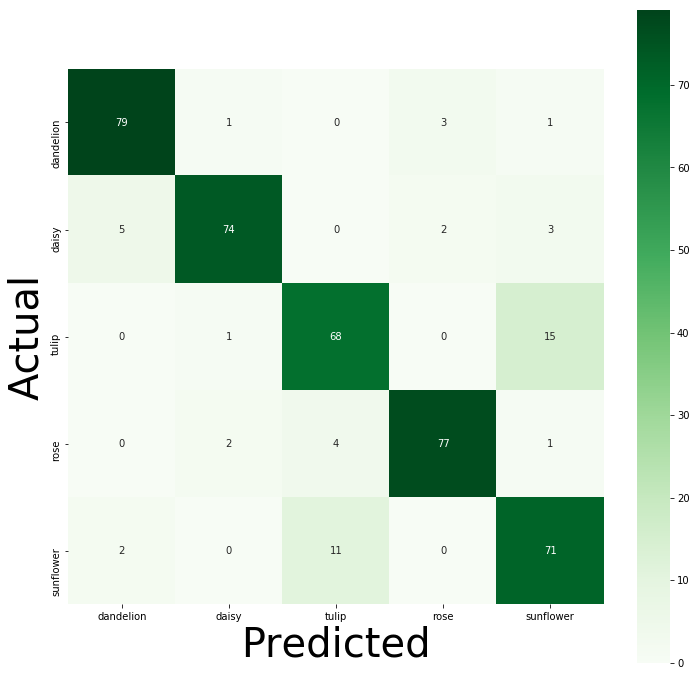

In [75]:
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=flower_types, yticklabels=flower_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

# Accuracy and Loss Curve

KeyError: 'val_accuracy'

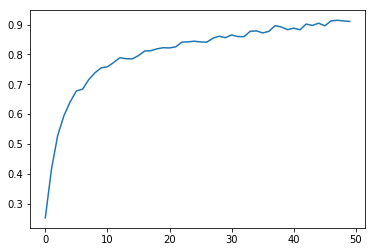

In [76]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Prediction 

In [ ]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('../input/flowers-recognition/flowers/sunflower/3893436870_034b79d118_n.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('../input/flowers-recognition/flowers/sunflower/3893436870_034b79d118_n.jpg', grayscale=False, target_size=(200, 200))
flower_types=['dandelion','daisy','tulip','rose','sunflower']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


x = np.array(x, 'float32')
#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',flower_types[ind])